# Fetch ML OA
Predict number of receipts for a given future month.

I know this is super late. I'm grateful if you're looking at this. Thank you for the opportunity!

## Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
receipts_2021_df = pd.read_csv("Daily Data.csv")
receipts_2021_df.head()

,# Date,Receipt_Count
0,2021-01-01,7564766
1,2021-01-02,7455524
2,2021-01-03,7095414
3,2021-01-04,7666163
4,2021-01-05,7771289


## Exploration and Prep

In [3]:
receipts_2021_df['# Date'] = pd.to_datetime(receipts_2021_df['# Date'], format='%Y-%m-%d')
receipts_2021_df["Month"] = receipts_2021_df["# Date"].dt.month
receipts_2021_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   # Date         365 non-null    datetime64[ns]
 1   Receipt_Count  365 non-null    int64         
 2   Month          365 non-null    int32         
dtypes: datetime64[ns](1), int32(1), int64(1)
memory usage: 7.3 KB


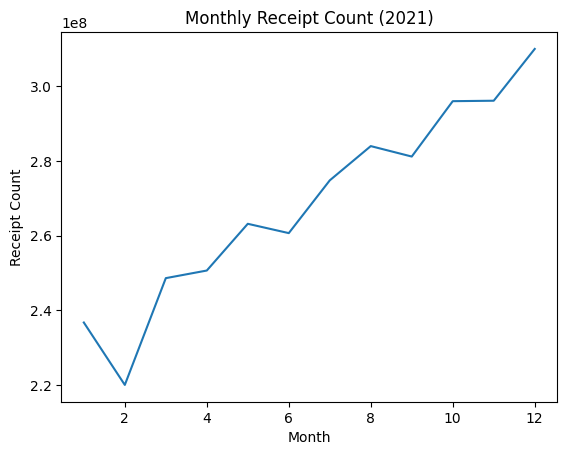

In [4]:
monthly_receipts = receipts_2021_df.groupby("Month")["Receipt_Count"].sum()

plt.plot(monthly_receipts)
plt.xlabel('Month')
plt.ylabel('Receipt Count')
plt.title('Monthly Receipt Count (2021)')
plt.show()

Notes:
- Relationship looks very linear. Models to try: Linear Regression with ridge penalty, and NN.
- Not enough data to create a validation/testing set, so we will test compared to the real 2021 values.

## Linear Regression with Ridge Penalty (Gradient Descent)

The ridge penalty is used in linear regression to prevent overfitting by adding a regularization term to the loss function. It helps to reduce the impact of large coefficients in the model, which can lead to overfitting.  

My code from a class assignment.

In [7]:
def MSE(y_values, yhat):
    return np.mean((y_values - yhat) ** 2)


def r_squared(y_values, yhat):
    ss_residual = np.sum((y_values - yhat) ** 2)
    ss_total = np.sum((y_values - np.mean(y_values)) ** 2)
    return 1 - (ss_residual / ss_total)


def adjusted_r_squared(y_values, yhat):
    n = len(y_values)
    p = 1 # only one predictor is this OA
    r2 = r_squared(y_values, yhat)
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)


def AIC(y_values, yhat):
    n = len(y_values)
    p = 1
    mse = MSE(y_values, yhat)
    aic = n * np.log(mse / n) + 2 * p
    return aic


def BIC(y_values, yhat):
    n = len(y_values)
    p = 1
    mse = MSE(y_values, yhat)
    bic = n * np.log(mse / n) + p * np.log(n)
    return bic

In [94]:
def predict(B, X):
    return np.sum(B * X, axis=1)


def ridge_gradient(X, y, B, lam):
    p = predict(B, X)

    t0 = (y * (1 - p))[:, np.newaxis] * X
    t1 = ((1 - y) * p)[:, np.newaxis] * X
    gradient = -1 * np.sum(t0 , axis=0) + np.sum(t1, axis=0)

    ridge_term = np.squeeze(2 * lam * B)
    gradient += ridge_term

    return gradient


def fit_linear_regression_ridge(X, y, lam, eta=0.001, decay_factor=1, max_iter=1e6):
    B = np.zeros(len(X[0]))
    
    i = 0
    while i < max_iter:
        gradient = ridge_gradient(X, y, B, lam)
        B_new = -eta * gradient + B
        eta = eta * decay_factor

        if np.sum(B - B_new) / len(B) < 0.01: # stopping condisiton
            return B_new

        B = B_new
        i += 1

    return B


def test_lambdas(X_train, y_train, lambdas, metric_f):
    results = []
    for lam in lambdas:
        B = fit_linear_regression_ridge(X_train, y_train, lam)
        metric = metric_f(y_train, predict(B, X_train))
        results.append((B, metric))
    return results


In [90]:
X_train = np.expand_dims(monthly_receipts.index.values, axis=1)
X_train = np.hstack((np.ones_like(X_train), X_train)) # intercept

y_train = np.array(monthly_receipts.values)

In [91]:
test_lambdas(X_train, y_train, [0.01, 0.1, 1, 5, 10, 20, 30, 50, 100, 1000], r_squared)

[(array([ 322169.6609, 2196617.4677]), -98.24549905073408),
 (array([ 322169.6609, 2196617.4677]), -98.24549905073408),
 (array([ 322169.6609, 2196617.4677]), -98.24549905073408),
 (array([ 322169.6609, 2196617.4677]), -98.24549905073408),
 (array([ 322169.6609, 2196617.4677]), -98.24549905073408),
 (array([ 322169.6609, 2196617.4677]), -98.24549905073408),
 (array([ 322169.6609, 2196617.4677]), -98.24549905073408),
 (array([ 322169.6609, 2196617.4677]), -98.24549905073408),
 (array([ 322169.6609, 2196617.4677]), -98.24549905073408),
 (array([ 322169.6609, 2196617.4677]), -98.24549905073408)]

In [92]:
lr_yhat = predict([322169.6609, 2196617.4677], X_train)
lr_yhat

array([ 2518787.1286,  4715404.5963,  6912022.064 ,  9108639.5317,
       11305256.9994, 13501874.4671, 15698491.9348, 17895109.4025,
       20091726.8702, 22288344.3379, 24484961.8056, 26681579.2733])

Notes:
- Lambda has no effect?
- Eta (learning rate) is very influential.

## PyTorch Neural Net Model

In [30]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [42]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


def train_model(model, train_loader, criterion, optimizer, num_epochs):
    loss = 0.0
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss = running_loss
    print(f"Final Loss: {running_loss/len(train_loader)}")

In [ ]:
X_train_nn = torch.Tensor(monthly_receipts.index.values)
y_train_nn = torch.Tensor(monthly_receipts.values)

train_dataset = TensorDataset(X_train_nn, y_train_nn)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [73]:
model = SimpleClassifier(input_size=12, hidden_size=100, output_size=12)
criterion = nn.MSELoss() # no concerns about outliers so MSE is reasonable
optimizer = optim.Adam(model.parameters(), lr=0.1)

train_model(model, train_loader, criterion, optimizer, num_epochs=100000)

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [01:48<00:00, 924.98it/s]

Final Loss: 40695393943552.0


In [74]:
nn_yhat = model(X_train_nn)
nn_yhat = nn_yhat.detach().numpy()
nn_yhat

array([2.2963280e+08, 2.3693947e+08, 2.4197048e+08, 2.5057509e+08,
       2.5833040e+08, 2.6404069e+08, 2.7317562e+08, 2.7881616e+08,
       2.8622333e+08, 2.9326054e+08, 3.0071514e+08, 3.0763123e+08],
      dtype=float32)

Notes:
- Seems overly complicated for what looks like a linear problem.


## Evaluation

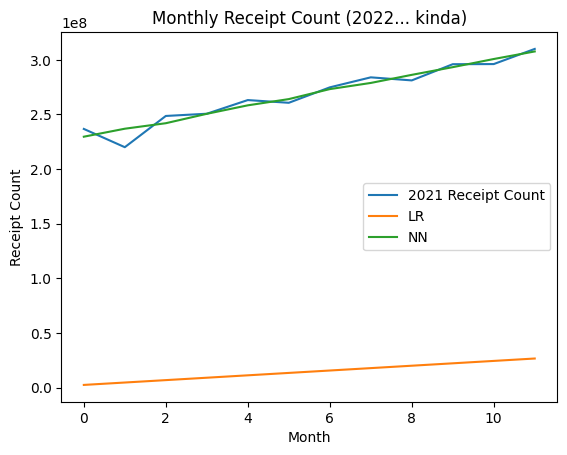

In [95]:
plt.plot(y_train, label='2021 Receipt Count')
plt.plot(lr_yhat, label='LR')
plt.plot(nn_yhat, label='NN')
plt.xlabel('Month')
plt.ylabel('Receipt Count')
plt.title('Monthly Receipt Count (2022... kinda)')
plt.legend()
plt.show()

Notes:
- In a realistic scenario, I would hopefully have more data so I don't test on the data I trained on. However, I think this is okay in this case as we have so limited data.
- Something is wrong with my Linear Regression model. Not sure why the interccept doesn't want to budge but the slope looks spot on.
- NN looks fantastic.